## Credit Card Fraud Detection

In this notebook, I have built a Neural Network to classify whether a given credit card transaction is fraud or not.

The dataset used in this notebook is the PCA transformed dataset on credit card transactions, which has been done so as to hide the sensitive details in the data

I have used SMOTE transformed data to train a Shallow Neural Network for the predictions

## Importing Libraries and Tools

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,roc_curve,roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

## Importing the Data

In [7]:
df=pd.read_csv("creditcard.csv")
df=df[df['Amount']!=0] #Removing entries with 0 transaction amount
df1=df[df['Class']==1]

## Exploratory Data Analysis

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,...,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000,282982.000000
mean,94848.963528,-0.000349,-0.002017,-0.003293,-0.011987,-0.002241,-0.001304,0.002510,0.000028,0.001465,...,-0.000049,-0.001609,0.000147,0.000201,-0.000508,-0.001365,0.000254,0.000193,88.919401,0.001643
std,47482.459589,1.956749,1.650490,1.514216,1.404850,1.378815,1.331592,1.233940,1.191173,1.099061,...,0.732650,0.725575,0.623032,0.605795,0.520985,0.481928,0.402986,0.330351,250.824374,0.040503
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.010000,0.000000
25%,54251.250000,-0.920128,-0.602287,-0.893646,-0.853056,-0.693746,-0.769031,-0.551877,-0.208947,-0.642803,...,-0.228981,-0.543990,-0.161743,-0.354714,-0.317651,-0.327900,-0.070787,-0.052889,5.990000,0.000000
50%,84707.500000,0.016891,0.062913,0.177459,-0.025952,-0.055518,-0.276678,0.041956,0.021510,-0.050516,...,-0.030056,0.004981,-0.011071,0.040981,0.015640,-0.054345,0.001340,0.011318,22.490000,0.000000
75%,139363.750000,1.315431,0.803483,1.022961,0.731168,0.610334,0.394015,0.571967,0.326754,0.598954,...,0.186199,0.527042,0.148023,0.439992,0.350331,0.239661,0.091351,0.078438,78.000000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


Text(0, 0.5, 'No of fraudulent transactions')

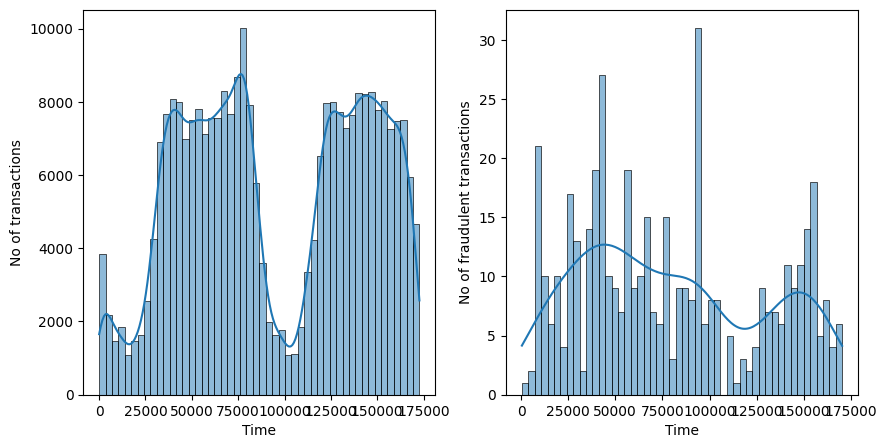

In [42]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
p1=sns.histplot(df['Time'],bins=50,kde=True,ax=ax[0])
p2=sns.histplot(df1['Time'],bins=50,kde=True,ax=ax[1])
p1.set_ylabel('No of transactions')
p2.set_ylabel('No of fraudulent transactions')

In [4]:
n=df.shape[0]
df.shape

(282982, 31)

<Axes: >

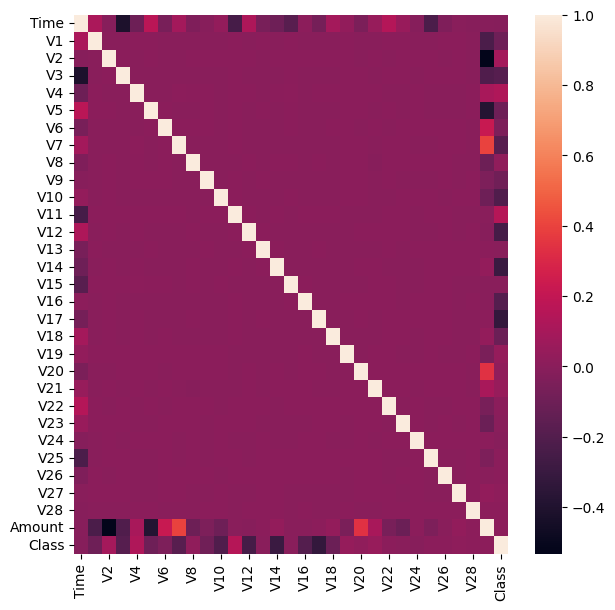

In [5]:
plt.subplots(figsize=(7,7))
sns.heatmap(df.corr())

(-5.287402987241516, 10.0)

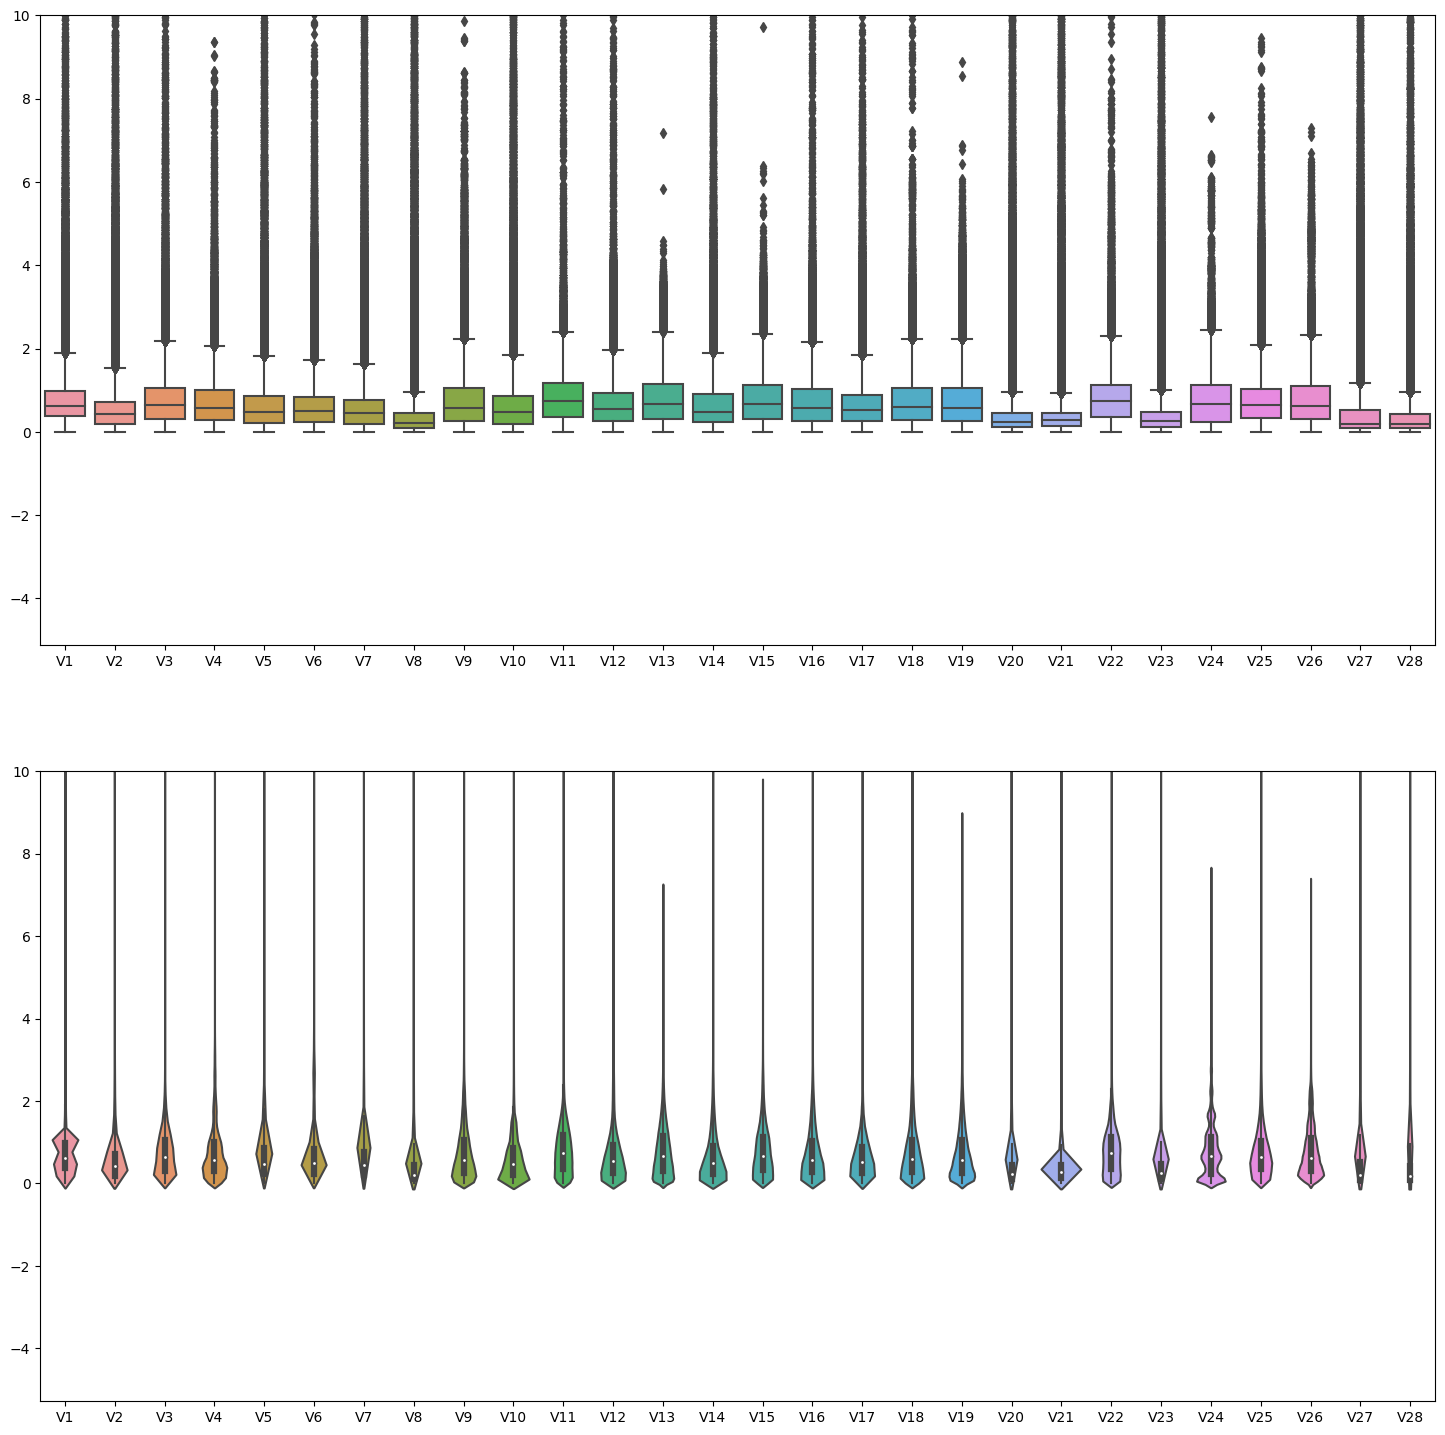

In [24]:
z_full=np.abs(zscore(df.drop(['Time','Amount','Class'],axis=1)))
fig,ax=plt.subplots(2,1,figsize=(18,18))
p3=sns.boxplot(data=z_full,ax=ax[0])
p4=sns.violinplot(data=z_full,ax=ax[1])
p3.set_ylim(top=10)
p4.set_ylim(top=10)

<Axes: >

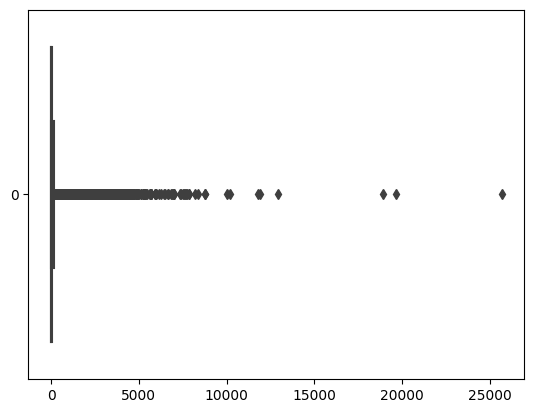

In [25]:
sns.boxplot(data=df['Amount'],orient="h")

In [26]:
print(z_full)

              V1        V2        V3        V4        V5        V6        V7   
0       0.694755  0.042875  1.677200  0.989532  0.243746  0.348224  0.192140  \
1       0.609280  0.162478  0.112120  0.327538  0.045153  0.060872  0.065897   
2       0.694012  0.810758  1.173218  0.278868  0.363325  1.353122  0.639377   
3       0.493637  0.111003  1.186283  0.605977  0.005852  0.937607  0.190528   
4       0.591740  0.533027  1.024962  0.295420  0.293697  0.073014  0.478493   
...          ...       ...       ...       ...       ...       ...       ...   
284802  6.071698  6.103533  6.492803  1.462557  3.889023  1.956710  3.987822   
284803  0.374315  0.032150  1.346126  0.517211  0.631319  0.795830  0.017683   
284804  0.981177  0.181302  2.143916  0.388541  1.909437  2.277402  0.242586   
284805  0.122699  0.322632  0.466119  0.499546  0.272496  0.469373  0.558123   
284806  0.272424  0.113734  0.466665  0.351842  0.007474  0.486872  1.275994   

              V8        V9       V10  .

(-6.4323431374896956, 15.0)

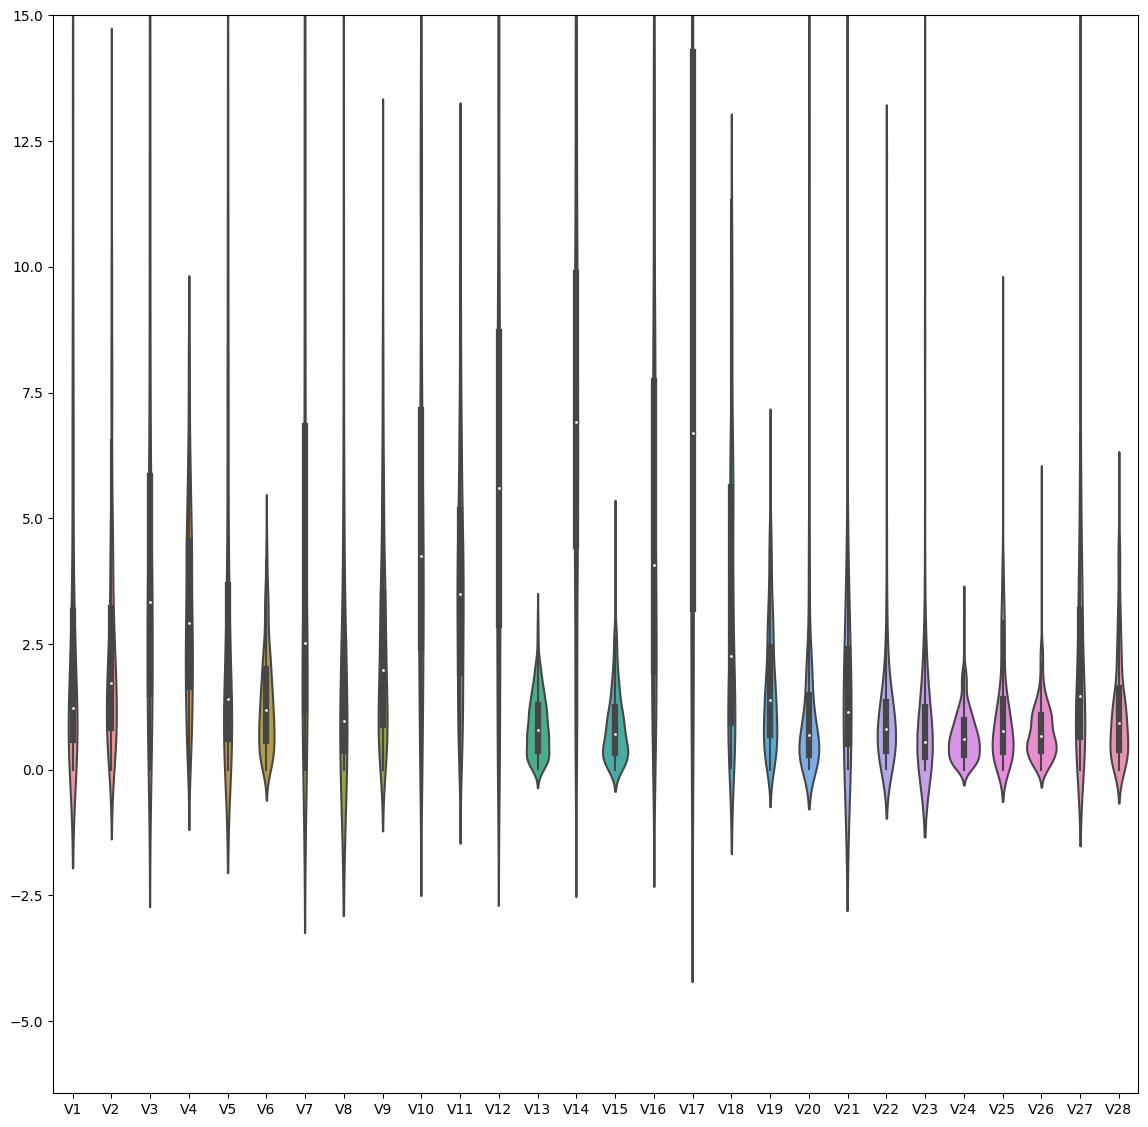

In [31]:
fig,ax=plt.subplots(figsize=(14,14))
p6=sns.violinplot(data=z_full[df['Class']==1])
p6.set_ylim(top=15)

## Splitting the Data into Training and Test Set

In [8]:
df_train_1,df_test_1=train_test_split(df[df.Class==1],test_size=0.4)
df_train_2,df_test_2=train_test_split(df[df.Class==0],test_size=0.33)
df_train=pd.concat([df_train_1,df_train_2])
df_test=pd.concat([df_test_1,df_test_2])
df_train.shape

(189565, 31)

In [9]:
z=np.abs(zscore(df_train.drop(['Time','Amount','Class'],axis=1)))

## Data Wrangling

In this step, I have transformed the training data by keeping the data near the decision boundary and removing the central data which has a very high probability of being Class=0.

In [10]:
df_clean=df_train[~((z<1.8).all(axis=1))]
df_clean

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
234633,148053.0,1.261324,2.726800,-5.435019,5.342759,1.447043,-1.442584,-0.898702,0.123062,-2.748496,...,0.209086,-0.425938,-0.154440,-0.018820,0.632234,0.192922,0.468181,0.280486,1.59,1
94218,64785.0,-8.744415,-3.420468,-4.850575,6.606846,-2.800546,0.105512,-3.269801,0.940378,-2.558691,...,0.102913,0.311626,-4.129195,0.034639,-1.133631,0.272265,1.841307,-1.796363,720.38,1
163586,116067.0,0.949241,1.333519,-4.855402,1.835006,-1.053245,-2.562826,-2.286986,0.260906,-0.895366,...,0.306598,-0.854627,0.101177,-0.281497,0.024444,-0.107944,0.625289,0.315677,65.00,1
154720,102676.0,-5.552122,5.678134,-9.775528,8.416295,-4.409844,-1.506235,-6.899839,3.750443,-3.879793,...,1.128472,0.228484,0.286258,-0.536294,-0.104925,0.420919,-0.297557,-0.946184,119.74,1
137705,82289.0,-1.464897,1.975528,-1.077145,2.819191,0.069850,-0.789044,-1.196101,0.673654,-1.363724,...,0.174099,-0.272505,-0.031549,-0.406166,0.157769,-0.104393,0.073796,-0.041570,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41925,40886.0,-7.595595,-0.705010,-2.671679,-1.422730,-6.007319,-0.871462,-2.042989,3.235032,-1.682403,...,-0.168608,-0.792352,-1.508334,0.777849,0.306765,-0.347220,0.248436,-0.342796,215.09,0
256171,157570.0,-1.475264,0.743424,-0.105992,-2.543007,0.315048,-0.752577,0.585087,-0.168103,-1.113539,...,0.105063,0.289364,-0.136990,-0.477820,0.120763,-0.453122,-0.719539,-0.132063,10.00,0
29469,35481.0,0.003943,0.228557,0.710912,0.109068,1.588486,4.504721,-1.149161,0.342877,0.237074,...,0.614185,-0.713753,-0.340399,1.006584,1.447347,-0.142883,0.155629,0.163805,24.99,0
175649,122429.0,-2.242281,-1.778039,0.956610,0.143072,3.578876,-2.562876,-0.572374,-0.120938,-0.268328,...,-0.167956,-1.133491,0.287201,0.996019,0.657225,0.250230,-0.378908,-0.205708,1.29,0


In [11]:
df_clean[df_clean['Class']==1].shape

(275, 31)

In [12]:
df_clean.shape
X=np.array(df_clean.drop(['Class'],axis=1))
y=np.array(df_clean['Class'])
x_test=np.array(df_test.drop(['Class'],axis=1))
y_test=np.array(df_test['Class'])

## Using SMOTE on the Data for Balancing Dataset 

As for training a neural network, we need a balanced dataset. To produce a balanced training set, I have used SMOTE(Synthetic Minority Oversampling Technique) to balance the data. SMOTE oversamples the given data by taking a linear combination of a minority class element with a randomly selected minority class of the five nearest neighbours.

In order to get better results, undersampling is also used to prevent overfitting the transformed data

In [13]:
def smo(df_clean,alpha):
    X=np.array(df_clean.drop(['Class'],axis=1))
    y=np.array(df_clean['Class'])
    over=SMOTE(sampling_strategy=alpha)
    under=RandomUnderSampler(sampling_strategy=0.5)
    s=[('o',over),('u',under)]
    pipline=Pipeline(steps=s)
    X1,y1=pipline.fit_resample(X,y)
    return X1,y1

    

## Training Neural Network on the SMOTE Transformed Data

In this step, I used the SMOTE transformed data to train a Shallow Neural Network to classify the transactions.Then checked its metrics on the orignal training and test data.

For selecting the hyperparamters , I maually tried different values of the hyperparameters and checked their metrics.
The best metrics were obtained using the following model

In [23]:
model=tf.keras.Sequential([
    tf.keras.layers.Dense(units=16,activation='relu',input_shape=(30,),name='layer1'),
    tf.keras.layers.Dense(units=32,activation='relu',name='layer2'),
    tf.keras.layers.Dense(units=1,activation='sigmoid',name='layer3')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 16)                496       
                                                                 
 layer2 (Dense)              (None, 32)                544       
                                                                 
 layer3 (Dense)              (None, 1)                 33        
                                                                 
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________


In [24]:
    X1,y1=smo(df_clean,0.27)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0018),loss=tf.keras.losses.BinaryCrossentropy())
    model.fit(X1,y1,epochs=13)

Epoch 1/13
2859/2859 [==============================] - 3s 981us/step - loss: 50.3617
Epoch 2/13
2859/2859 [==============================] - 3s 945us/step - loss: 16.5998
Epoch 3/13
2859/2859 [==============================] - 3s 947us/step - loss: 10.5310
Epoch 4/13
2859/2859 [==============================] - 3s 947us/step - loss: 6.6488
Epoch 5/13
2859/2859 [==============================] - 3s 947us/step - loss: 5.0606
Epoch 6/13
2859/2859 [==============================] - 3s 946us/step - loss: 3.5321
Epoch 7/13
2859/2859 [==============================] - 3s 947us/step - loss: 2.8503
Epoch 8/13
2859/2859 [==============================] - 3s 962us/step - loss: 1.7290
Epoch 9/13
2859/2859 [==============================] - 3s 951us/step - loss: 1.3333
Epoch 10/13
2859/2859 [==============================] - 3s 979us/step - loss: 0.9966
Epoch 11/13
2859/2859 [==============================] - 3s 945us/step - loss: 0.6997
Epoch 12/13
2859/2859 [==============================] - 3s 

## Predicting the  Results of the Neural Network

In [25]:
y_pred_train=np.array(model.predict(X))
y_pred_train[y_pred_train>0.8]=1
y_pred_train[y_pred_train<=0.8]=0
y_pred_test=np.array(model.predict(x_test))
y_pred_test[y_pred_test>0.8]=1
y_pred_test[y_pred_test<=0.8]=0


2920/2920 [==============================] - 2s 692us/step


In [39]:
print("Training Set F1 Score:  ",f1_score(y,y_pred_train))
print("Test Set F1 Score:  ",f1_score(y_test,y_pred_test))


Training Set F1 Score:   0.8163992869875223
Test Set F1 Score:   0.8121546961325966


In [36]:
a=confusion_matrix(y_pred_train,y)
print("Training Set Confusion Matrix:")
print(a)
print("\n")
b=confusion_matrix(y_pred_test,y_test)
print("Test Set Confusion Matrix:")
print(b)     

Training Set Confusion Matrix:
[[112856     46]
 [    57    229]]


Test Set Confusion Matrix:
[[93202    39]
 [   29   147]]


## Visualizing the Layer Parameters

<Axes: >

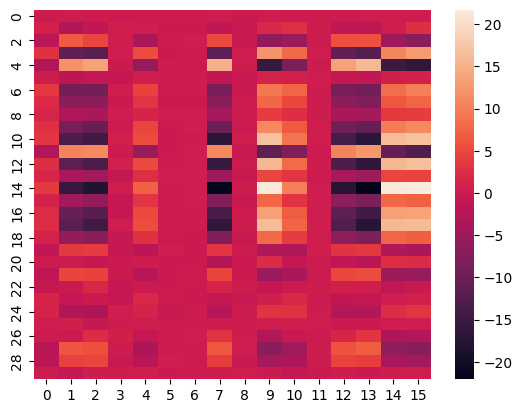

In [47]:
W1,b1=model.layers[0].weights
sns.heatmap(W1)

From the above plot we see that columns 1-18 ie, V1 to V18 are more important while classifying fraudulent transactions over 
column 0(Time of transaction) or columns V19-V28

<Axes: >

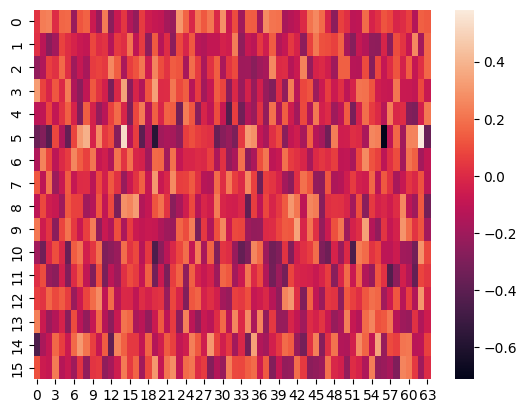

In [59]:
W2,b2=model.layers[1].weights
sns.heatmap(W2)


<Axes: >

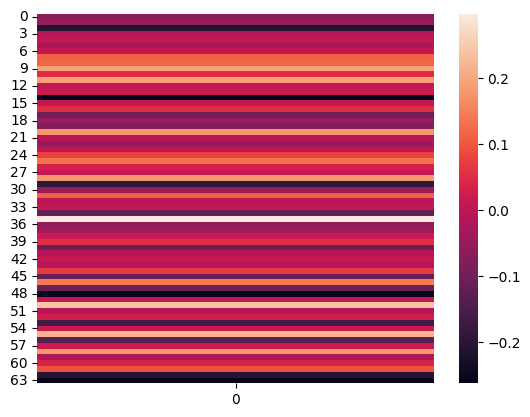

In [60]:
W3,b3=model.layers[2].weights
sns.heatmap(W3)

In [34]:
model.save('my_model.hdf5')